In [1]:
# from glob import glob
# import datetime as dt
import os
os.chdir('/g/data/vf71/la6889/lme_scale_calibration_ISMIP3a/new_workflow/')

In [2]:
import xarray as xr
import json
import pandas as pd
import numpy as np
import useful_functions as uf

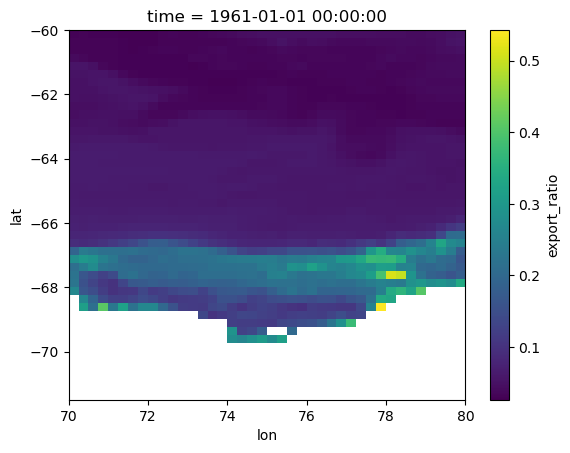

In [3]:
sinking_rate = xr.open_zarr(os.path.join(
    '/g/data/vf71/la6889/dbpm_inputs/east_antarctica/gridded', 
    'gfdl-mom6-cobalt2_obsclim_er_15arcmin_fao-58_monthly_1961_2010.zarr/'))
sinking_rate = (sinking_rate['export_ratio'].sel(time = '1961').
                sel(lat = slice(-60, None), lon = slice(70, 80)))
sinking_rate.isel(time = 0).plot()

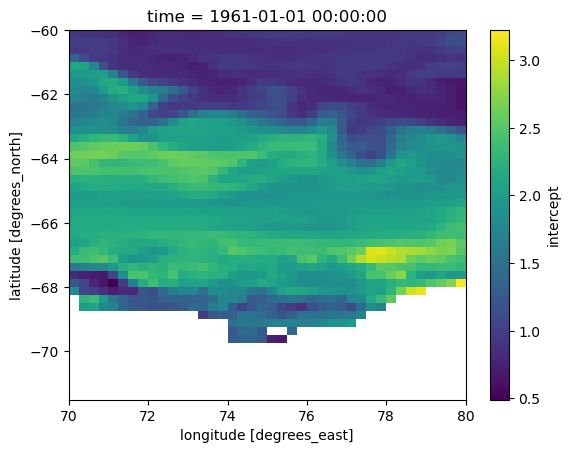

In [20]:
int_phy_zoo = xr.open_zarr(os.path.join(
    '/g/data/vf71/la6889/dbpm_inputs/east_antarctica/gridded', 
    'gfdl-mom6-cobalt2_obsclim_intercept_15arcmin_fao-58_monthly_1961_2010.zarr/'))
int_phy_zoo = (int_phy_zoo['intercept'].sel(time = '1961').
                sel(lat = slice(-60, None), lon = slice(70, 80)))
int_phy_zoo.isel(time = 0).plot()

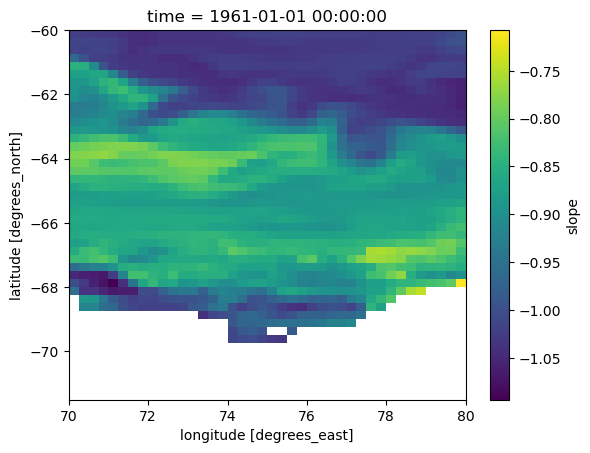

In [21]:
slope_phy_zoo_mat = xr.open_zarr(os.path.join(
    '/g/data/vf71/la6889/dbpm_inputs/east_antarctica/gridded', 
    'gfdl-mom6-cobalt2_obsclim_slope_15arcmin_fao-58_monthly_1961_2010.zarr/'))
slope_phy_zoo_mat = (slope_phy_zoo_mat['slope'].sel(time = '1961').
                sel(lat = slice(-60, None), lon = slice(70, 80)))
slope_phy_zoo_mat.isel(time = 0).plot()

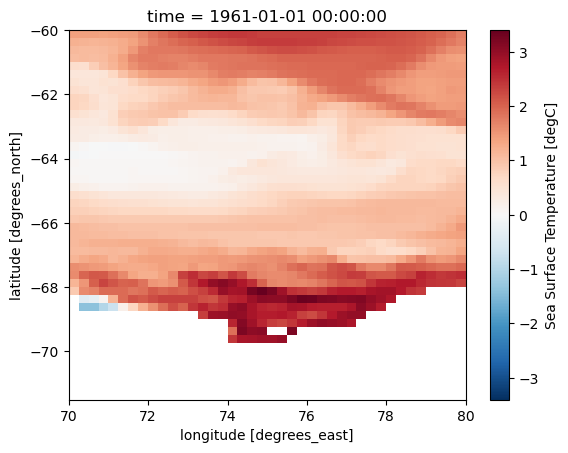

In [11]:
sea_surf_temp = xr.open_zarr(os.path.join(
    '/g/data/vf71/la6889/dbpm_inputs/east_antarctica/gridded', 
    'gfdl-mom6-cobalt2_obsclim_tos_15arcmin_fao-58_monthly_1961_2010.zarr/'))
sea_surf_temp = (sea_surf_temp['tos'].sel(time = '1961').
                sel(lat = slice(-60, None), lon = slice(70, 80)))
sea_surf_temp.isel(time = 0).plot()

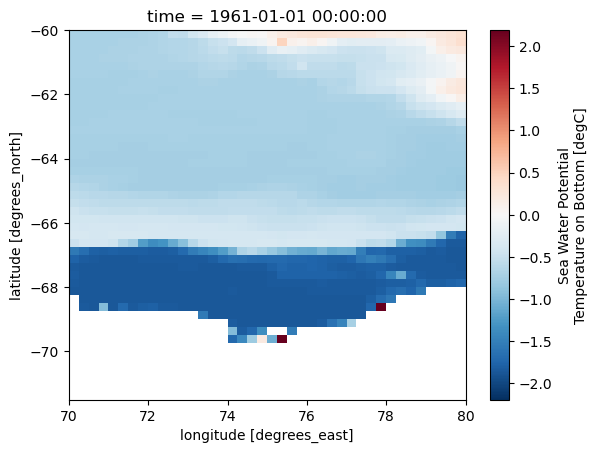

In [22]:
sea_floor_temp = xr.open_zarr(os.path.join(
    '/g/data/vf71/la6889/dbpm_inputs/east_antarctica/gridded', 
    'gfdl-mom6-cobalt2_obsclim_tob_15arcmin_fao-58_monthly_1961_2010.zarr/'))
sea_floor_temp = (sea_floor_temp['tob'].sel(time = '1961').
       sel(lat = slice(-60, None), lon = slice(70, 80)))
sea_floor_temp.isel(time = 0).plot()

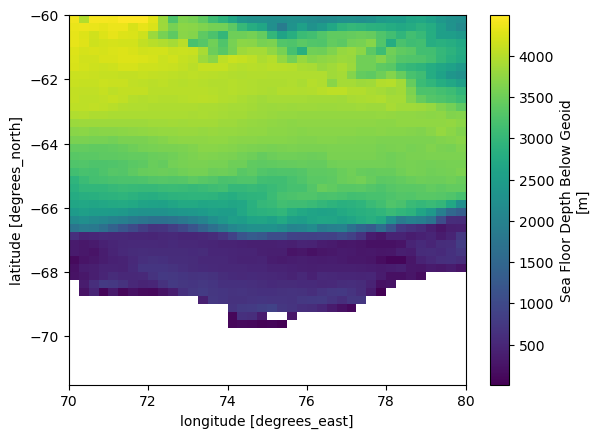

In [23]:
depth = xr.open_zarr(os.path.join(
    '/g/data/vf71/la6889/dbpm_inputs/east_antarctica/gridded', 
    'gfdl-mom6-cobalt2_obsclim_deptho_15arcmin_fao-58_fixed.zarr/'))['deptho']
depth = depth.sel(lat = slice(-60, None), lon = slice(70, 80))
depth.plot()

In [15]:
#Non-gridded
# params = json.load(open('params_testing.json'))
#Gridded 
gridded_params = json.load(open('gridded_params_testing.json'))

In [18]:
dbpm_input = pd.read_parquet(
    os.path.join('/g/data/vf71/la6889/lme_scale_calibration_ISMIP3a/data',
                 'dbpm_clim-fish-inputs_fao-58_1841-2010.parquet'))
dbpm_input = dbpm_input[dbpm_input.year == 1960].reset_index(drop = True)

## Parameters from `sizemodel` function

In [16]:
ERSEM_det_input = False
temp_effect = True
use_init = True

In [24]:
[timesteps_years] = gridded_params['timesteps_years']
[numb_size_bins] =  gridded_params['numb_size_bins']
[numb_time_steps] = gridded_params['numb_time_steps']
[ind_min_detritivore_size] = np.array(gridded_params['ind_min_detritivore_size'])-1

#Indexes for predator density
idx = np.array(gridded_params['idx'])-1
idx_new = np.arange(ind_min_detritivore_size+1, numb_size_bins)

log10_size_bins = np.array(gridded_params['log10_size_bins'])
[log_size_increase] = gridded_params['log_size_increase']
log10_size_bins_mat = xr.DataArray(data = log10_size_bins, 
                               dims = ['size_class'], 
                               coords = {'size_class': log10_size_bins})
size_bin_vals = 10**log10_size_bins_mat
effort = (xr.DataArray(gridded_params['effort'], dims = 'time', 
                       coords = {'time': sinking_rate.time}).
          expand_dims({'lat': sinking_rate.lat, 'lon': sinking_rate.lon}).
          transpose('time', 'lat', 'lon'))
time = np.array(pd.date_range(dbpm_input.time.min()-pd.DateOffset(months = 1),
                                  dbpm_input.time.max(), freq = 'MS'),
                    dtype = 'datetime64[ns]')
[log10_pred_prey_ratio] = gridded_params['log10_pred_prey_ratio']
[log_prey_pref] = gridded_params['log_prey_pref']
[metabolic_req_pred] = gridded_params['metabolic_req_pred']
[metabolic_req_detritivore] = gridded_params['metabolic_req_detritivore']
[ind_min_pred_size] = np.array(gridded_params['ind_min_pred_size'])-1
[ind_min_fish_det] = (np.array(gridded_params['ind_min_fish_det'])-1).astype('int')
[ind_min_fish_pred] = (np.array(gridded_params['ind_min_fish_pred'])-1).astype('int')
pref_benthos = (0.8*np.exp((-1/250*depth)))
pref_pelagic = (1-pref_benthos)
init_pred = (xr.DataArray(data = gridded_params['init_pred'], 
                         dims = ['size_class'], 
                         coords = {'size_class': log10_size_bins}).
            expand_dims({'lat': sinking_rate.lat, 'lon': sinking_rate.lon}))
init_detritivores = (xr.DataArray(data = gridded_params['init_detritivores'], 
                                  dims = ['size_class'], 
                                  coords = {'size_class': log10_size_bins}).
                    expand_dims({'lat': sinking_rate.lat, 'lon': sinking_rate.lon}))
ui0 = 10**int_phy_zoo

In [13]:
# dbpm_input_time = np.array(dbpm_input.time, dtype = 'datetime64[ns]')

In [15]:
constant_growth = uf.gphi_f(uf.pred_prey_matrix(log10_size_bins), 
                            log10_pred_prey_ratio, log_prey_pref)
constant_mortality = uf.mphi_f(-uf.pred_prey_matrix(log10_size_bins), 
                               log10_pred_prey_ratio, log_prey_pref, metabolic_req_pred)
met_req_log10_size_bins = uf.expax_f(log10_size_bins_mat, metabolic_req_pred)

In [16]:
predators = ui0*(10**(slope_phy_zoo_mat*log10_size_bins_mat))
predators = xr.where(predators.size_class < log10_size_bins[ind_min_pred_size],
                     predators, 0)
predators = xr.concat([predators.isel(time = 0), predators], dim = 'time')
predators['time'] = time

detritivores = xr.zeros_like(predators)

detritus = xr.zeros_like(predators.isel(size_class = 0).drop_vars('size_class'))
detritus.loc[{'time': detritus.time.min()}] = gridded_params['init_detritus']

In [17]:
if use_init:
    predators = xr.where((predators.size_class >= log10_size_bins[ind_min_pred_size]) &
                         (predators.time == predators.time.min()),
                         init_pred, predators)
    detritivores = xr.where((detritivores.size_class >= log10_size_bins[ind_min_detritivore_size]) &
                        (detritivores.time == detritivores.time.min()), 
                        init_detritivores, detritivores)
else:
    predators = xr.where((predators.size_class >= log10_size_bins[ind_min_pred_size]) &
                         (predators.size_class < log10_size_bins[120]) &
                         (predators.time == predators.time.min()),
                         init_pred, predators)
    detritivores = xr.where((detritivores.size_class >= log10_size_bins[ind_min_detritivore_size]) &
                        (detritivores.size_class < log10_size_bins[120]) &
                        (detritivores.time == detritivores.time.min()), 
                        init_detritivores, detritivores)

In [18]:
other_mort_det = gridded_params['natural_mort']*10**(-0.25*log10_size_bins_mat)
other_mort_pred = gridded_params['natural_mort']*10**(-0.25*log10_size_bins_mat)

In [20]:
senes_mort_det = (gridded_params['const_senescence_mort']*
                  10**(gridded_params['exp_senescence_mort']*
                       (log10_size_bins_mat-gridded_params['size_senescence'])))
senes_mort_pred = (gridded_params['const_senescence_mort']*
                   10**(gridded_params['exp_senescence_mort']*
                        (log10_size_bins_mat-gridded_params['size_senescence'])))

In [21]:
fishing_mort_pred = xr.zeros_like(predators)
fishing_mort_pred = xr.where((fishing_mort_pred.size_class >= log10_size_bins[ind_min_fish_pred]) &
                             (fishing_mort_pred.size_class < fishing_mort_pred.size_class.max()) & 
                             (fishing_mort_pred.time == fishing_mort_pred.time.min()), 
                             gridded_params['fish_mort_pred']*effort.isel(time = 0), 
                             fishing_mort_pred)

fishing_mort_det = xr.zeros_like(detritivores)
fishing_mort_det = xr.where((fishing_mort_det.size_class >= log10_size_bins[ind_min_fish_det]) &
                            (fishing_mort_det.size_class < fishing_mort_det.size_class.max()) & 
                            (fishing_mort_det.time == fishing_mort_det.time.min()), 
                            gridded_params['fish_mort_detritivore']*effort.isel(time = 0), 
                            fishing_mort_det)

In [22]:
catch_pred = xr.where((predators.time == predators.time.min()) &
                      (predators.size_class >= log10_size_bins[ind_min_fish_pred]) &
                      (predators.size_class < predators.size_class.max()), 
                      fishing_mort_pred*predators*size_bin_vals, 0)

catch_det = xr.where((detritivores.time == detritivores.time.min()) &
                     (detritivores.size_class >= log10_size_bins[ind_min_fish_det]) &
                     (detritivores.size_class < detritivores.size_class.max()),
                     fishing_mort_det*detritivores*size_bin_vals, 0)

In [23]:
#Multipliers that do not require iteration
#Size bin related
size_multi = size_bin_vals*log_size_increase

#To be applied to feeding rates for pelagics and benthic groups
feed_mult_pel = (gridded_params['hr_volume_search']*
                 (10**(log10_size_bins_mat*metabolic_req_pred))*
                 pref_pelagic)

feed_mult_ben = (gridded_params['hr_volume_search']*
                 (10**(log10_size_bins_mat*metabolic_req_pred))*
                pref_benthos)

In [33]:
if temp_effect:
    #Adding time dimension to temperature effect for pelagic group
    pel_tempeffect = np.exp(gridded_params['c1']-
                            gridded_params['activation_energy']/
                            (gridded_params['boltzmann']*(sea_surf_temp+273)))
    
    #Adding time dimension to temperature effect for benthic group
    ben_tempeffect = np.exp(gridded_params['c1']-
                            gridded_params['activation_energy']/
                            (gridded_params['boltzmann']*(sea_floor_temp+273)))
else:
    pel_tempeffect = 1
    ben_tempeffect = 1

In [ ]:
reprod_det = xr.zeros_like(predators)
reprod_pred = xr.zeros_like(predators)
growth_det = xr.zeros_like(predators)
growth_int_pred = xr.zeros_like(predators)
pred_mort_det = xr.zeros_like(predators)
pred_mort_pred = xr.zeros_like(predators)
tot_mort_det = xr.zeros_like(predators)
tot_mort_pred = xr.zeros_like(predators)

# Time loop starts here

In [197]:
for i in range(0, numb_time_steps):
    t = sinking_rate.time[i].values
    ts = time[i]
    print(i, t, ts)

0 1961-01-01 00:00:00 1959-12-01T00:00:00.000000000
1 1961-02-01 00:00:00 1960-01-01T00:00:00.000000000
2 1961-03-01 00:00:00 1960-02-01T00:00:00.000000000
3 1961-04-01 00:00:00 1960-03-01T00:00:00.000000000
4 1961-05-01 00:00:00 1960-04-01T00:00:00.000000000
5 1961-06-01 00:00:00 1960-05-01T00:00:00.000000000
6 1961-07-01 00:00:00 1960-06-01T00:00:00.000000000
7 1961-08-01 00:00:00 1960-07-01T00:00:00.000000000
8 1961-09-01 00:00:00 1960-08-01T00:00:00.000000000
9 1961-10-01 00:00:00 1960-09-01T00:00:00.000000000
10 1961-11-01 00:00:00 1960-10-01T00:00:00.000000000
11 1961-12-01 00:00:00 1960-11-01T00:00:00.000000000


In [223]:
i = 0
t = sinking_rate.time[i].values
ts = time[i]
pred_short = predators.sel(time = ts)
detrit_short = detritivores.sel(time = ts)

In [247]:
if i+1 < numb_time_steps:
    fish_bio_pred = (pred_short.isel(size_class = slice(ind_min_fish_pred, -1))*
                     size_multi).sum('size_class')
    fish_bio_det = (detrit_short.isel(size_class = slice(ind_min_fish_det, -1))*
                     size_multi).sum('size_class')
    
    prop_b = ((fish_bio_pred+fish_bio_det))/(fish_bio_pred+fish_bio_det).sum()
    prop_b = prop_b.drop_vars('time')

    effort.loc[{'time': effort.time[i+1]}] = uf.gravitymodel(effort.isel(time = i+1),
                                                             prop_b, depth, 1)

# Grid cell loop starts here

In [89]:
feed_mult_pel = (params['hr_volume_search']*
                 10**(log10_size_bins_mat*metabolic_req_pred)*
                 params['pref_pelagic'])

feed_mult_ben = (params['hr_volume_search']*
                 10**(log10_size_bins_mat*metabolic_req_pred)*
                 params['pref_benthos'])

growth_prop = 1-np.array(params['defecate_prop'])
high_prop = 1-np.array(params['def_low'])

In [90]:
i = 0
t = dbpm_input.time[i]
ts = time[i]

In [91]:
t

Timestamp('1960-01-01 00:00:00')

In [92]:
ts

numpy.datetime64('1959-12-01T00:00:00.000000000')

In [93]:
pred_short = predators.sel(time = ts)
detrit_short = detritivores.sel(time = ts)

In [94]:
pred_growth = (feed_mult_pel*
               np.dot((pred_short*log_size_increase),
                      constant_growth))
feed_rate_pel = (pel_tempeffect.sel(time = t)*
                 (pred_growth/(1+params['handling']*pred_growth)))

detrit_growth = (feed_mult_ben*
                 np.dot((detrit_short*log_size_increase),
                        constant_growth))

feed_rate_bent = (pel_tempeffect.sel(time = t)*
                 (detrit_growth/(1+params['handling']*detrit_growth)))

detritus_multiplier = ((1/size_bin_vals)*params['hr_vol_filter_benthos']*
                       10**(log10_size_bins_mat*metabolic_req_detritivore)*
                       detritus.sel(time = ts))
feed_rate_det = (ben_tempeffect.sel(time = t)*detritus_multiplier/
                 (1+params['handling']*detritus_multiplier))

In [95]:
growth_int_pred.loc[{'time': ts}] = (growth_prop*params['growth_pred']*
                                     feed_rate_pel+high_prop*
                                     params['growth_detritivore']*feed_rate_bent)

In [96]:
reprod_pred.loc[{'time': ts}] = (growth_prop*
                                 (1-(np.array(params['growth_pred'])+
                                     params['energy_pred']))*
                                 feed_rate_pel+growth_prop*
                                 (1-(np.array(params['growth_detritivore'])+
                                     params['energy_detritivore']))*
                                 feed_rate_bent)

In [97]:
sat_pel = xr.where(feed_rate_pel > 0, feed_rate_pel/pred_growth, 0)

In [98]:
pred_mort_pred.loc[{'time': ts}] = ((params['pref_pelagic']*met_req_log10_size_bins*
                                    params['hr_volume_search'])*
                                    np.dot((pred_short*sat_pel*
                                            log_size_increase), 
                                           constant_mortality))

tot_mort_pred.loc[{'time': ts}] = (pred_mort_pred.sel(time = ts)+
                                   pel_tempeffect.sel(time = t)*
                                   other_mort_pred+senes_mort_pred+
                                   fishing_mort_pred.sel(time = t))

In [99]:
growth_det.loc[{'time': ts}] = high_prop*params['growth_detritus']*feed_rate_det
reprod_det.loc[{'time': ts}] = (high_prop*(1-(np.array(params['growth_detritus'])+
                                              params['energy_detritivore']))*
                                feed_rate_det)

In [100]:
divisor = ((params['hr_volume_search']*
            10**(log10_size_bins_mat*metabolic_req_detritivore)*
            params['pref_benthos'])*
           np.dot((detrit_short*log_size_increase), 
                                     constant_growth))
sat_ben = xr.where(feed_rate_bent > 0, feed_rate_bent/divisor, 0)

pred_mort_det.loc[{'time': ts}] = xr.where(sat_ben > 0, 
                                           ((params['pref_benthos']*
                                             met_req_log10_size_bins*
                                             params['hr_volume_search'])*
                                            np.dot((pred_short*
                                                    sat_ben*log_size_increase),
                                                   constant_mortality)), 0)

tot_mort_det.loc[{'time': ts}] = (pred_mort_det.sel(time = ts)+
                                  ben_tempeffect.sel(time = t)*other_mort_det+
                                  senes_mort_det+fishing_mort_det.sel(time = t))

In [101]:
output_w = (size_bin_vals*feed_rate_det*detrit_short*log_size_increase).sum()

defbypred = (params['defecate_prop']*feed_rate_pel*size_bin_vals*
             pred_short+params['def_low']*feed_rate_bent*
             size_bin_vals*pred_short)

In [102]:
input_w = (sinking_rate.sel(time = t)* 
                   ((defbypred.isel(size_class = slice(ind_min_pred_size, numb_size_bins))*
                     log_size_increase).sum()+
                    (pel_tempeffect.sel(time = t)*other_mort_pred*
                     pred_short*size_bin_vals*
                     log_size_increase).sum()+ 
                    (pel_tempeffect.sel(time = t)*senes_mort_pred*
                     pred_short*size_bin_vals*
                     log_size_increase).sum())+
                   ((ben_tempeffect.sel(time = t)*other_mort_det*
                     detrit_short*size_bin_vals*
                     log_size_increase).sum()+ 
                    (ben_tempeffect.sel(time = t)*senes_mort_det*
                     detrit_short*size_bin_vals*
                     log_size_increase).sum()))

burial = input_w*(0.013+0.53*input_w**2/(7+input_w)**2)

dW = input_w-(output_w+burial)

detritus.loc[{'time': t}] = detritus.sel(time = ts)+dW*timesteps_years

In [103]:
Ai_u = np.zeros(numb_size_bins)
Bi_u = np.zeros(numb_size_bins)
Si_u = np.zeros(numb_size_bins)

Ai_u[idx] = ((1/np.log(10))*
             -growth_int_pred.isel(size_class = slice(None, -1)).
             sel(time = ts)*timesteps_years/log_size_increase)
Bi_u[idx] = (1+(1/np.log(10))*
             growth_int_pred.isel(size_class = slice(1, None)).
             sel(time = ts)*timesteps_years/log_size_increase+
             tot_mort_pred.isel(size_class = slice(1, None)).
             sel(time = ts)*timesteps_years)
Si_u[idx] = pred_short.isel(size_class = slice(1, None))

Ai_u[ind_min_pred_size] = 0
Bi_u[ind_min_pred_size] = 1
Si_u[ind_min_pred_size] = pred_short.isel(size_class = ind_min_pred_size)

In [104]:
predators.isel(size_class = ind_min_pred_size).\
            loc[{'time': t}] = (pred_short.isel(size_class = ind_min_pred_size)+
                                ((reprod_pred.sel(time = ts)*size_bin_vals*
                                  pred_short*log_size_increase).
                                 isel(size_class = slice(ind_min_pred_size+1, None)).
                                 sum()*timesteps_years)/
                                (log_size_increase*
                                 size_bin_vals.isel(size_class = ind_min_pred_size))-
                                (timesteps_years/log_size_increase)*(1/np.log(10))*
                                ((growth_int_pred.sel(time = ts)*pred_short).
                                 isel(size_class = ind_min_pred_size))-
                                timesteps_years*
                                ((tot_mort_pred.sel(time = ts)*pred_short).
                                 isel(size_class = ind_min_pred_size)))

for j in range((ind_min_pred_size+1), numb_size_bins):
        predators.isel(size_class = j).\
        loc[{'time': t}] = ((Si_u[j]-Ai_u[j]*predators.sel(time = t).
                             isel(size_class = j-1))/
                            Bi_u[j])

In [105]:
Ai_v = np.zeros(numb_size_bins)
Bi_v = np.zeros(numb_size_bins)
Si_v = np.zeros(numb_size_bins)

#shorthand for matrix referencing
Ai_v[idx_new] = ((1/np.log(10))*-growth_det.isel(size_class = idx_new-1).sel(time = ts)*
                 timesteps_years/log_size_increase)
Bi_v[idx_new] = (1+(1/np.log(10))*growth_det.isel(size_class = idx_new).sel(time = ts)*
                 timesteps_years/log_size_increase+
                 tot_mort_det.isel(size_class = idx_new).sel(time = ts)*timesteps_years)
Si_v[idx_new] = detrit_short.isel(size_class = idx_new)

#boundary condition at upstream end
Ai_v[ind_min_detritivore_size] = 0
Bi_v[ind_min_detritivore_size] = 1
Si_v[ind_min_detritivore_size] = detrit_short.isel(size_class = ind_min_detritivore_size)

In [106]:
(detritivores.isel(size_class = slice(None, ind_min_detritivore_size+1)).
 loc[{'time': t}]) = detrit_short.isel(size_class = slice(None, ind_min_detritivore_size+1))

In [107]:
(detritivores.isel(size_class = ind_min_detritivore_size).
 loc[{'time': t}]) = (detrit_short.isel(size_class = ind_min_detritivore_size)+
                      ((reprod_det.sel(time = ts)*size_bin_vals*
                        detrit_short*log_size_increase).
                       isel(size_class = idx_new).sum()*timesteps_years)/
                      (log_size_increase*
                       size_bin_vals.isel(size_class = ind_min_detritivore_size))-
                      (timesteps_years/log_size_increase)*(1/np.log(10))*
                      ((growth_det.sel(time = ts)*detrit_short).
                       isel(size_class = ind_min_detritivore_size))-
                      timesteps_years*
                      ((tot_mort_det.sel(time = ts)*detrit_short).
                       isel(size_class = ind_min_detritivore_size)))

In [108]:
for j in idx_new:
            detritivores.isel(size_class = j).\
            loc[{'time': t}] = ((Si_v[j]-Ai_v[j]*detritivores.isel(size_class = j-1).\
                                 sel(time = t))/Bi_v[j])

In [109]:
predators = predators.isel(size_class = slice(ind_min_fish_pred,
                                              numb_size_bins))
detritivores = detritivores.isel(size_class = slice(ind_min_fish_det,
                                                    numb_size_bins))

In [114]:
(catch_pred.isel(size_class = slice(ind_min_fish_pred, numb_size_bins)).
 loc[:,dbpm_input_time]) = (fishing_mort_pred*predators*size_bin_vals)

#output fisheries catches per yr at size
(catch_det.isel(size_class = slice(ind_min_fish_det, numb_size_bins)).
 loc[:,dbpm_input_time]) = (fishing_mort_det*detritivores*size_bin_vals)

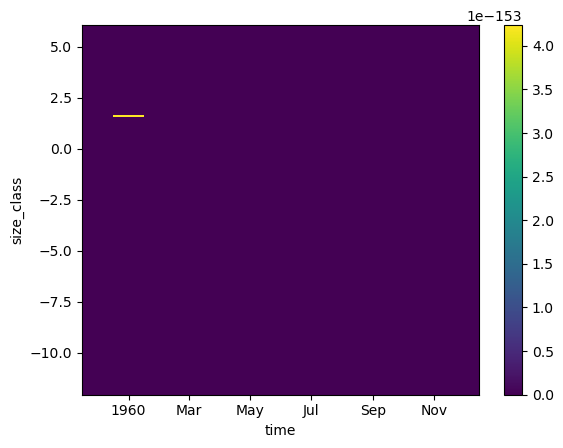

In [115]:
catch_det.plot()

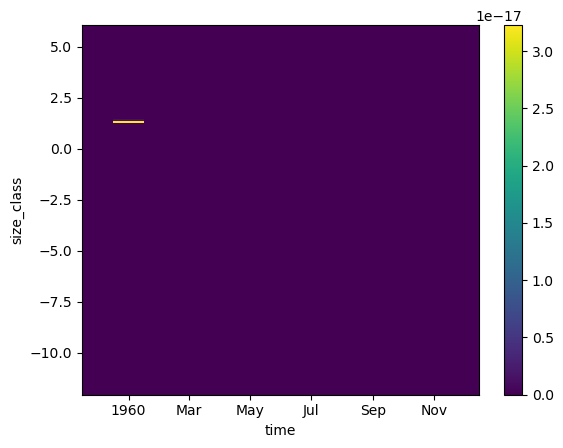

In [116]:
catch_pred.plot()

In [8]:
params['numb_size_bins']

[181]

In [9]:
test['predators'].isel(size_class = slice(2, None))

<xarray.DataArray (size_class: 47, time: 2041)> Size: 767kB
array([[0.00000000e+000, 8.35325730e-012, 1.72911473e-010, ...,
        2.77024749e-001, 2.76607524e-001, 2.76726207e-001],
       [0.00000000e+000, 7.75357176e-013, 1.81591955e-011, ...,
        2.00162012e-001, 2.00058229e-001, 2.00306079e-001],
       [0.00000000e+000, 6.61818195e-014, 1.75470442e-012, ...,
        1.41885397e-001, 1.41925789e-001, 1.42196581e-001],
       ...,
       [0.00000000e+000, 3.34034488e-135, 2.87496853e-130, ...,
        4.09848372e-031, 3.97874489e-031, 3.88393825e-031],
       [0.00000000e+000, 4.12648187e-141, 4.74730862e-136, ...,
        2.72970325e-033, 2.64375103e-033, 2.57558149e-033],
       [0.00000000e+000, 3.20992281e-147, 4.96432498e-142, ...,
        1.48758560e-035, 1.43753170e-035, 1.39728066e-035]])
Coordinates:
  * size_class  (size_class) float64 376B 1.4 1.5 1.6 1.7 ... 5.7 5.8 5.9 6.0
  * time        (time) datetime64[ns] 16kB 1840-12-01 1841-01-01 ... 2010-12-01